In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, SpectralAnomalyScoreExt)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score

import scipy as sp
import scipy.fftpack
import skimage as ski

from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

/home/markus/.local/lib/python3.7/site-packages/iotfunctions/bif.py:1986: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


In [2]:
# setting to make life easier
Temperature='Temperature'
kmeans='TemperatureKmeansScore'
fft='TemperatureFFTScore'
spectral='TemperatureSpectralScore'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

#kmeans_break=1.3
#spectral_break = 2.8
#fft_break = 100
#sal_break = 100
#gen_break = 30000
kmeans_break=100
spectral_break = 100
fft_break = 100
sal_break = 100
gen_break = 30000


In [3]:

# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('./samples/AzureAnomalysample.csv', index_col=False, parse_dates=['timestamp'])

df_i['id']='MyRoom'
df_i['Temperature']=df_i['value'] + 20
df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['id','timestamp']).dropna()

df_i.head(2)

Temperature
id     timestamp                       
MyRoom 2017-10-09 20:32:00         23.0
       2017-10-09 20:33:00         23.0

In [4]:
# Now run the anomaly functions as if they were executed in a pipeline

spsi = SpectralAnomalyScoreExt(Temperature, 12, spectral, 'inv_zscore')
et = spsi._build_entity_type(columns = [Column(Temperature,Float())])
spsi._entity_type = et
df_i = spsi.execute(df=df_i)

sali = SaliencybasedGeneralizedAnomalyScore(Temperature, 12, sal)
et = sali._build_entity_type(columns = [Column(Temperature,Float())])
sali._entity_type = et
df_i = sali.execute(df=df_i)

ffti = FFTbasedGeneralizedAnomalyScore(Temperature, 12, fft)
et = ffti._build_entity_type(columns = [Column(Temperature,Float())])
ffti._entity_type = et
df_i = ffti.execute(df=df_i)

kmi = KMeansAnomalyScore(Temperature, 2, kmeans)
et = kmi._build_entity_type(columns = [Column(Temperature,Float())])
kmi._entity_type = et
df_i = kmi.execute(df=df_i)

df_i.head(4)

2020-03-19T09:59:50.174 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-03-19T09:59:50.175 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
                         id  Temperature  TemperatureSpectralScore_x  \
timestamp                                                              
2017-10-09 20:32:00  MyRoom         23.0                           0   
2017-10-09 20:33:00  MyRoom         23.0                           0   
2017-10-09 20:34:00  MyRoom         23.0                           0   

                     TemperatureSpectralScore_y  inv_zscore  
timestamp                                                    
2017-10-09 20:32:00                    6.444541     0.05493  
2017-10-09 20:33:00                    6.420078     0.05493  
2017-10-09 20:34:00                    6.395615     0.05493  
2020-03-19T09

Temperature  TemperatureSpectralScore  inv_zscore  \
id     timestamp                                                                
MyRoom 2017-10-09 20:32:00         23.0                  6.444541     0.05493   
       2017-10-09 20:33:00         23.0                  6.420078     0.05493   
       2017-10-09 20:34:00         23.0                  6.395615     0.05493   
       2017-10-09 20:35:00         23.0                  6.371152     0.05493   

                            SaliencyAnomalyScore  TemperatureFFTScore  \
id     timestamp                                                        
MyRoom 2017-10-09 20:32:00             18.681470            -3.663992   
       2017-10-09 20:33:00             17.935261            -2.655597   
       2017-10-09 20:34:00             17.189053            -1.647202   
       2017-10-09 20:35:00             16.442845            -0.638806   

                            TemperatureKmeansScore  
id     timestamp                                    
MyRoom 2017-10-09 20:32:00                0.067216  
       2017-10-09 20:33:00                0.067216  
       2017-10-09 20:34:00                0.067216  
       2017-10-09 20:35:00                0.067216

In [5]:
# Simplify our pandas dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)

df_inputm2 = df_i.loc[['MyRoom']]
df_inputm2.reset_index(level=[0], inplace=True)

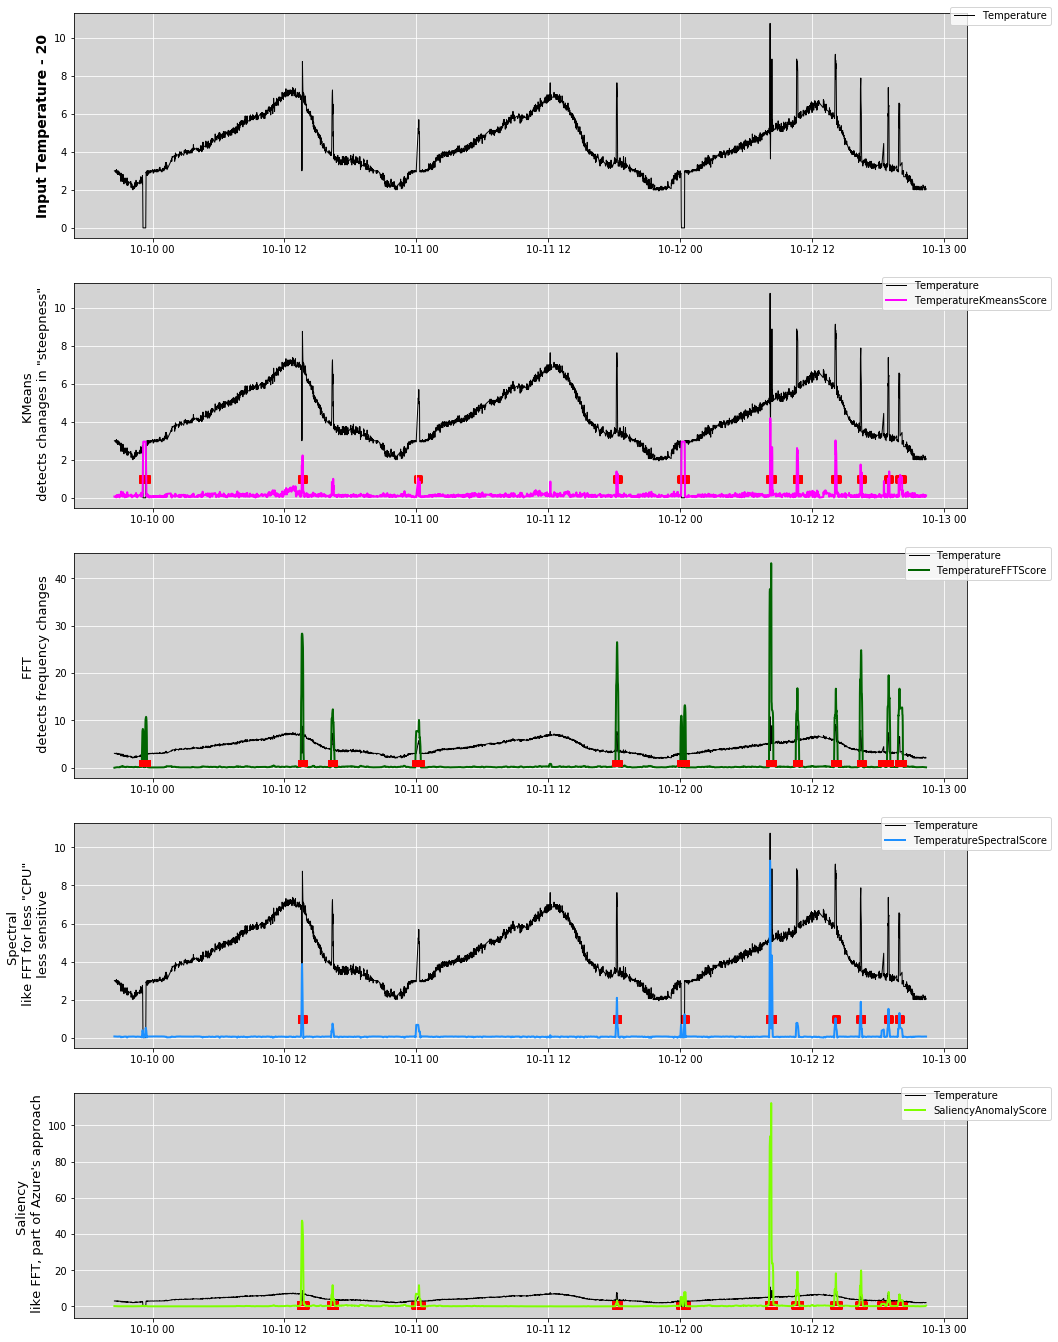

In [14]:
# Scale and plot
kmeans_break = 1.0
df_inputm2[kmeansA] = df_inputm2[kmeans]
df_inputm2[kmeansA].values[df_inputm2[kmeansA] < kmeans_break] = np.nan
df_inputm2[kmeansA].values[df_inputm2[kmeansA] > kmeans_break] = kmeans_break

df_inputm2[fftA] = df_inputm2[fft]
df_inputm2[fftA].values[df_inputm2[fftA] < fft_break] = np.nan
df_inputm2[fftA].values[df_inputm2[fftA] > fft_break] = fft_break
df_inputm2[spectralA] = df_inputm2[spectral]
df_inputm2[spectralA].values[df_inputm2[spectralA] < spectral_break] = np.nan
df_inputm2[spectralA].values[df_inputm2[spectralA] > spectral_break] = spectral_break
df_inputm2[salA] = df_inputm2[sal]
df_inputm2[salA].values[df_inputm2[salA] < sal_break] = np.nan
df_inputm2[salA].values[df_inputm2[salA] > sal_break] = sal_break

plots = 5
anolw = 3

fig, ax = plt.subplots(plots, 1, figsize=(16,24))
cnt = 0
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input Temperature - 20',fontsize=14,weight="bold")
cnt = 1
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].scatter(df_inputm2.index, df_inputm2[kmeansA], linewidth=anolw, marker='s', color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects chanages in "steepness"',fontsize=13)
cnt = 2
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputm2.index, df_inputm2[fftA]/fft_break, linewidth=anolw, marker='s', color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects frequency changes', fontsize=13)
cnt = 3
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].scatter(df_inputm2.index, df_inputm2[spectralA]/spectral_break, linewidth=anolw, marker='s', color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n like FFT for less "CPU"\n less sensitive', fontsize=13)
cnt = 4
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[sal]/sal_break, linewidth=2,color='chartreuse', label=sal)
ax[cnt].scatter(df_inputm2.index, df_inputm2[salA]/sal_break, linewidth=anolw, marker='s', color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n like FFT, part of Azure\'s approach', fontsize=13)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')

In [65]:
EngineLogging.configure_console_logging(logging.ERROR)
df_inputm2.index.size
df_inputm3 = df_inputm2.copy()
df_inputm3 = df_inputm3.reset_index().set_index(['id','timestamp'])

anomalies = np.logical_not(np.isnan(df_inputm2[fftA].values))

In [156]:
from tabulate import tabulate
from timeit import Timer

def test_FFT(overlap):
    duration = dt.datetime.now()
    anomalies2 = np.zeros(4000)
    for i in range(overlap,4000,overlap):
        df_temp = df_inputm3.iloc[i-overlap:i+overlap,:].copy()
        ffti2 = FFTbasedGeneralizedAnomalyScore(Temperature, 12, fft)
        et = ffti2._build_entity_type(columns = [Column(Temperature,Float())])
        ffti2._entity_type = et
        df_temp = ffti2.execute(df=df_temp)
        anomalies2[i-overlap:i+overlap] = np.maximum(anomalies2[i-overlap:i+overlap], df_temp[fft].values / 100)
    
    anomalies3 = np.where(anomalies2 > 1, True, False)
    accuracy = np.logical_xor(anomalies3, anomalies)
    duration = dt.datetime.now() - duration
    return duration, accuracy, anomalies2
                            
    #df_ho = df_inputm2[].copy

In [157]:
table = [["Overlap", "Execution time", "Accuracy"]]
for i in (50, 100, 200,400, 500, 1000, 2000):
    d, ac, anomal = test_FFT(i)
    if i == 50:
        ano50 = anomal
    elif i == 100:
        ano100 = anomal
    table.append([i, d, np.sum(ac)])
print(tabulate(table))

-------  --------------  --------
Overlap  Execution time  Accuracy
50       0:00:03.237953  274
100      0:00:01.879460  71
200      0:00:01.190592  8
400      0:00:04.494495  6
500      0:00:03.982586  7
1000     0:00:02.666200  4
2000     0:00:01.240223  0
-------  --------------  --------


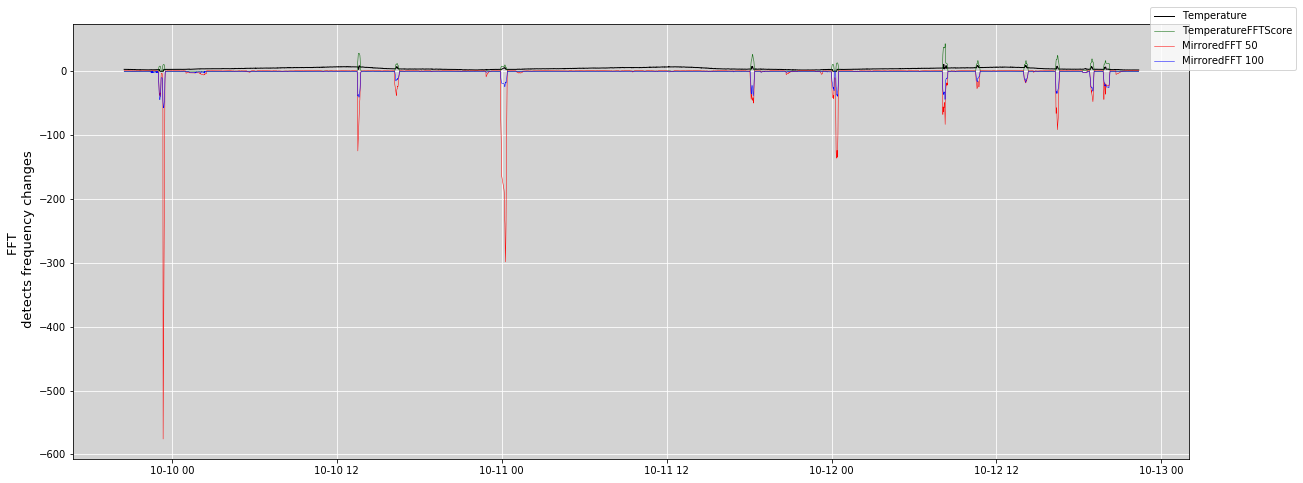

In [161]:
# Scale and plot

plots = 1
anolw = 3
sqze = plots > 1

fig, ax_ = plt.subplots(plots, 1, figsize=(20,plots*8))
ax = np.atleast_1d(ax_).ravel()
cnt = 0
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[fft]/fft_break, linewidth=0.5,color='darkgreen',label=fft)
ax[cnt].plot(df_inputm2.index, -ano50+1, linewidth=0.5,color='red',label='MirroredFFT 50')
ax[cnt].plot(df_inputm2.index, -ano100, linewidth=0.5,color='blue',label='MirroredFFT 100')
#ax[cnt].plot(df_inputm2.index, df_inputm2[fftA]/fft_break, linewidth=anolw, marker='s', color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects frequency changes', fontsize=13)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')